In [ ]:
!git clone https://github.com/ArseniyBolotin/TTS.git

In [ ]:
!pip3 install -r TTS/requirements.txt

In [ ]:
!sh ./TTS/download.sh

In [4]:
from itertools import islice
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

from TTS.aligner import GraphemeAligner
from TTS.collate import LJSpeechCollator
from TTS.dataset import LJSpeechDataset
from TTS.featurizer import MelSpectrogram, MelSpectrogramConfig
from TTS.model import FastSpeech
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

fast_speech = FastSpeech().to(device)

dataloader = DataLoader(LJSpeechDataset('./data/dataset/LJSpeech'), batch_size=3, collate_fn=LJSpeechCollator())
batch = list(islice(dataloader, 1))[0]
aligner = GraphemeAligner().to(device)
batch.durations = aligner(
    batch.waveform.to(device), batch.waveform_length, batch.transcript
)
featurizer = MelSpectrogram(MelSpectrogramConfig())
waveform = batch.waveform
mels = featurizer(waveform).to(device)
tokens = batch.tokens.to(device)
durations = batch.durations.to(device) * mels.shape[-1]
mels = mels.transpose(1, 2)
n_epochs = 2000
output_step = 100

fast_speech.train()
preds_loss = nn.MSELoss()
durations_criterion = nn.MSELoss()

optimizer = optim.Adam(fast_speech.parameters(), lr=3e-4, betas=(0.9, 0.98), eps=1e-9)

for epoch in range(1, n_epochs + 1):
    preds, duration_preds = fast_speech(tokens, durations)
    optimizer.zero_grad()
    common_shape = min(preds.size(1), mels.size(1))
    durations_loss = durations_criterion(duration_preds, durations)
    loss = preds_loss(preds[:, :common_shape, :], mels[:, :common_shape, :]) + durations_loss
    loss.backward()
    optimizer.step()
    if epoch % output_step == 0:
        print(f"Epoch #{epoch} loss: {loss.item()}")
        print(f"durations loss: {durations_loss.item()}")

Epoch #100 loss: 23.944232940673828
durations loss: 21.347307205200195
Epoch #200 loss: 2.3490161895751953
durations loss: 0.9271059036254883
Epoch #300 loss: 0.9052150845527649
durations loss: 0.09383908659219742
Epoch #400 loss: 0.2869601249694824
durations loss: 0.012918209657073021
Epoch #500 loss: 0.1550218164920807
durations loss: 0.00432635797187686
Epoch #600 loss: 0.18970242142677307
durations loss: 0.09290523827075958
Epoch #700 loss: 0.08747565746307373
durations loss: 0.028894761577248573
Epoch #800 loss: 0.03934042900800705
durations loss: 0.0014673785772174597
Epoch #900 loss: 0.48080945014953613
durations loss: 0.2196066528558731
Epoch #1000 loss: 0.027306171134114265
durations loss: 0.0005570814246311784
Epoch #1100 loss: 0.06496208906173706
durations loss: 0.013454117812216282
Epoch #1200 loss: 0.03303932771086693
durations loss: 0.0009854413801804185
Epoch #1300 loss: 0.025188613682985306
durations loss: 0.003275069175288081
Epoch #1400 loss: 0.05655878037214279
durat

In [5]:
!git clone https://github.com/NVIDIA/waveglow.git
!pip install googledrivedownloader

fatal: destination path 'waveglow' already exists and is not an empty directory.


In [6]:
from google_drive_downloader import GoogleDriveDownloader as gdd

In [7]:
gdd.download_file_from_google_drive(
    file_id='1rpK8CzAAirq9sWZhe9nlfvxMF1dRgFbF',
    dest_path='./waveglow_256channels_universal_v5.pt'
)

In [8]:
batch.transcript[0]

'Printing, in the only sense with which we are at present concerned, differs from most if not from all the arts and crafts represented in the Exhibition'

/usr/local/lib/python3.7/dist-packages/torch/serialization.py:671: SourceChangeWarning: source code of class 'torch.nn.modules.conv.ConvTranspose1d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/local/lib/python3.7/dist-packages/torch/serialization.py:671: SourceChangeWarning: source code of class 'torch.nn.modules.container.ModuleList' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/local/lib/python3.7/dist-packages/torch/serialization.py:671: SourceChangeWarning: source code of class 'torch.nn.modules.conv.Conv1d' has changed. you can retrieve the original source code by accessing the object's source attribute or

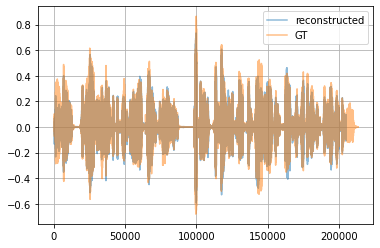

In [9]:
from TTS.vocoder import Vocoder
from IPython import display
import matplotlib.pyplot as plt

vocoder = Vocoder().to(device).eval()
fast_speech.eval()
reconstructed_wav = vocoder.inference(fast_speech(tokens, durations)[0][:1].transpose(1, 2)).cpu()
plt.plot(reconstructed_wav[0], label='reconstructed', alpha=.5)
plt.plot(batch.waveform[0], label='GT', alpha=.5)
plt.grid()
plt.legend()
plt.show()
display.display(display.Audio(reconstructed_wav[0], rate=22050))
display.display(display.Audio(batch.waveform[0], rate=22050))

In [10]:
torch.save(fast_speech, 'fast_speech_checkpoint.pt')

In [11]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [12]:
from googleapiclient.http import MediaFileUpload
from googleapiclient.discovery import build


drive_service = build('drive', 'v3')

file_metadata = {
  'name': 'fast_speech_checkpoint.pt'
}
media = MediaFileUpload('fast_speech_checkpoint.pt', 
                        resumable=True)
created = drive_service.files().create(body=file_metadata,
                                       media_body=media,
                                       fields='id').execute()
print('File ID: {}'.format(created.get('id')))



File ID: 1xbgiyf5g7zEvLpwVbiOK5hdtrQ_CRGP9


In [13]:
!gdown --id 1xbgiyf5g7zEvLpwVbiOK5hdtrQ_CRGP9

Downloading...
From: https://drive.google.com/uc?id=1xbgiyf5g7zEvLpwVbiOK5hdtrQ_CRGP9
To: /content/fast_speech_checkpoint.pt
100% 210M/210M [00:01<00:00, 194MB/s]
